In [67]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, TensorDataset, Subset

from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.fftpack import fft
import numpy as np
from sklearn.model_selection import KFold

In [68]:
# Load them up
fitted_wc = np.load("../outputs/results/basic_fit/wc_curves.npy")
fitted_lc = np.load("../outputs/results/basic_fit/lc_curves.npy")
gt_df = pd.read_csv("../outputs/train_labels.csv")
gt_df = gt_df.iloc[:, ::-1]  # rememver to reverse the columns - bloody hell
gt_df = gt_df.to_numpy()
airs = np.load("../data/processed/kaggle_sub_processed/airs_v4.npy")
airs = airs.sum(axis=3)  # sum over spatial dimension

Generate training and validation indices ----->

In [69]:
train_labels = pd.read_csv("../data/raw/train_labels.csv")
star_labels = pd.read_csv("../data/raw/train_adc_info.csv")
# the train data is aligned with the star data
sum(train_labels.planet_id != star_labels.planet_id)

0

In [70]:
def generate_indices(star_types, k_folds=5, unseen_prop=0.7, random_state=None):
    indices_star_type_0 = np.where(star_types == 0)[0]
    indices_star_type_1 = np.where(star_types == 1)[0]

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

    train_indices_list = []
    val_indices_list = []

    for train_index, val_index in kf.split(indices_star_type_0):
        # Training indices for star type 0
        train_indices = indices_star_type_0[train_index]

        # Validation indices for star type 0 (OOF)
        val_indices_oof = indices_star_type_0[val_index]

        # Random sampling of star type 1 for validation
        val_indices_star_type_1 = np.random.choice(
            indices_star_type_1,
            size=int(len(val_indices_oof) * unseen_prop),
            replace=False,
        )

        # Combine validation indices
        val_indices = np.concatenate([val_indices_oof, val_indices_star_type_1])

        train_indices_list.append(train_indices)
        val_indices_list.append(val_indices)

    return train_indices_list, val_indices_list


# Example usage
star_types = star_labels.star
train_indices_list, val_indices_list = generate_indices(
    star_types, k_folds=5, random_state=42
)

In [71]:
def compute_spectral_density(signal):
    # Perform the Fast Fourier Transform (FFT)
    fft_values = np.fft.fft(signal)

    # Calculate the Power Spectral Density
    psd = np.abs(fft_values) ** 2 / len(signal)

    return psd

In [72]:
# data input to our model
normalized_wc = fitted_wc / fitted_wc[:, :10].mean(axis=1, keepdims=True)
normalized_lc = fitted_lc / fitted_lc[:, :10, :].mean(axis=1, keepdims=True)

mean_wc = normalized_wc.mean(axis=1, keepdims=True)
mean_lc = normalized_lc.mean(axis=1, keepdims=True)
mean_airs = airs.mean(axis=1, keepdims=True)

demeaned_wc = normalized_wc - mean_wc
demeaned_lc = normalized_lc - mean_lc
demeaned_airs = airs - mean_airs

psd_lc = compute_spectral_density(demeaned_lc)
psd_airs = compute_spectral_density(demeaned_airs)

normalized_psd_lc = psd_lc / np.percentile(psd_lc, 95, axis=1, keepdims=True)
normalized_psd_airs = psd_airs / np.percentile(psd_airs, 95, axis=1, keepdims=True)

In [73]:
class CNN_RNN_Model(nn.Module):
    def __init__(self, time_steps, n_frequencies, hidden_size=64, num_layers=2):
        super(CNN_RNN_Model, self).__init__()

        # Convolutional layers for cleaned and raw time series data
        self.conv1 = nn.Conv2d(
            in_channels=2, out_channels=32, kernel_size=(5, 3), stride=(1, 1)
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(3, 5), stride=(1, 1)
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1)
        )

        # Calculate the output dimensions after convolution and pooling
        dummy_input = torch.zeros(1, 2, time_steps, n_frequencies)
        conv_output_shape = self._get_conv_output(dummy_input)

        # LSTM for sequential learning
        self.lstm = nn.LSTM(
            input_size=conv_output_shape[2],
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
        )

        # Convolutional layers for PSD data
        self.conv_psd1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv_psd2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool_psd = nn.MaxPool2d(kernel_size=(2, 2))

        # Calculate the output dimensions after convolution and pooling for PSD data
        dummy_psd_input = torch.zeros(1, 1, time_steps, n_frequencies)
        psd_output_shape = self._get_psd_conv_output(dummy_psd_input)

        # Fully connected layers for final prediction
        self.fc1 = nn.Linear(
            hidden_size
            + psd_output_shape[1] * psd_output_shape[2] * psd_output_shape[3],
            128,
        )
        self.fc2 = nn.Linear(128, n_frequencies)

    def _get_conv_output(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        return x.view(
            x.size(0), x.size(2), -1
        ).shape  # Output as (batch, time_steps, features)

    def _get_psd_conv_output(self, x):
        x = self.pool_psd(F.relu(self.conv_psd1(x)))
        x = self.pool_psd(F.relu(self.conv_psd2(x)))
        return x.shape  # Output shape

    def forward(self, x_clean, x_raw, x_psd):
        # Combine cleaned and raw time series data as two channels
        x_combined = torch.stack((x_clean, x_raw), dim=1)
        # print(f"x_combined shape after stacking: {x_combined.shape}")

        # Apply convolutional layers to combined time series data
        x_combined = self.pool(F.relu(self.conv1(x_combined)))
        # print(f"x_combined shape after conv1 and pool: {x_combined.shape}")
        x_combined = self.pool(F.relu(self.conv2(x_combined)))
        # print(f"x_combined shape after conv2 and pool: {x_combined.shape}")
        x_combined = F.relu(self.conv3(x_combined))
        # print(f"x_combined shape after conv3: {x_combined.shape}")

        # Reshape for LSTM input
        x_combined = x_combined.view(
            x_combined.size(0), x_combined.size(2), -1
        )  # (batch_size, new_time_steps, new_features)
        # print(f"x_combined shape after view: {x_combined.shape}")

        # LSTM layer
        x_combined, _ = self.lstm(x_combined)
        # print(f"x_combined shape after LSTM: {x_combined.shape}")

        # Use the output of the last LSTM time step
        x_combined = x_combined[:, -1, :]
        # print(f"x_combined shape after selecting last time step: {x_combined.shape}")

        # Apply convolutional layers to PSD data
        x_psd = x_psd.unsqueeze(1)  # Add a channel dimension
        # print(f"x_psd shape after unsqueeze: {x_psd.shape}")
        x_psd = self.pool_psd(F.relu(self.conv_psd1(x_psd)))
        # print(f"x_psd shape after conv_psd1 and pool_psd: {x_psd.shape}")
        x_psd = self.pool_psd(F.relu(self.conv_psd2(x_psd)))
        # print(f"x_psd shape after conv_psd2 and pool_psd: {x_psd.shape}")
        x_psd = x_psd.view(x_psd.size(0), -1)  # Flatten
        # print(f"x_psd shape after view: {x_psd.shape}")

        # Concatenate features from both branches
        x = torch.cat((x_combined, x_psd), dim=1)
        # print(f"x shape after concatenation: {x.shape}")

        # Fully connected layers for final prediction
        x = F.relu(self.fc1(x))
        # print(f"x shape after fc1: {x.shape}")
        x = self.fc2(x)
        # print(f"x shape after fc2: {x.shape}")

        return x


# Example usage
model = CNN_RNN_Model(time_steps=187, n_frequencies=282)

In [74]:
model

CNN_RNN_Model(
  (conv1): Conv2d(2, 32, kernel_size=(5, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (lstm): LSTM(8448, 64, num_layers=2, batch_first=True)
  (conv_psd1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_psd2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_psd): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=206144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=282, bias=True)
)

In [75]:
# Create DataLoader
example_clean = torch.from_numpy(demeaned_lc).float()
example_raw = torch.from_numpy(demeaned_airs).float()
example_psd = torch.from_numpy(normalized_psd_lc).float()
targets = torch.from_numpy(gt_df[:, :-2]).float()

In [76]:
output = model(example_clean, example_raw, example_psd)
print(output.shape)  # Should be (16, 283)

torch.Size([673, 282])


In [77]:
# Create DataLoader
dataset = TensorDataset(example_clean, example_raw, example_psd, targets)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 3
best_val_loss = float("inf")
patience_counter = 0

# Training loop
num_epochs = 10
k_folds = len(train_indices_list)
for fold in range(k_folds):
    print(f"Fold {fold+1}/{k_folds}")

    train_indices = train_indices_list[fold]
    val_indices = val_indices_list[fold]

    # Create DataLoader for training and validation sets
    train_subset = Subset(
        TensorDataset(example_clean, example_raw, example_psd, targets), train_indices
    )
    val_subset = Subset(
        TensorDataset(example_clean, example_raw, example_psd, targets), val_indices
    )
    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (x_clean, x_raw, x_psd, target) in enumerate(train_loader):
            # Move data to the same device as the model
            x_clean, x_raw, x_psd, target = (
                x_clean.to(device),
                x_raw.to(device),
                x_psd.to(device),
                target.to(device),
            )

            optimizer.zero_grad()
            outputs = model(x_clean, x_raw, x_psd)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (x_clean, x_raw, x_psd, target) in enumerate(val_loader):
                x_clean, x_raw, x_psd, target = (
                    x_clean.to(device),
                    x_raw.to(device),
                    x_psd.to(device),
                    target.to(device),
                )
                outputs = model(x_clean, x_raw, x_psd)
                loss = criterion(outputs, target)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

print("Training complete.")

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

Using device: cpu
Fold 1/5
Epoch [1/10], Training Loss: 2.0306
Epoch [1/10], Validation Loss: 0.0027
Epoch [2/10], Training Loss: 0.0027
Epoch [2/10], Validation Loss: 0.0026
Epoch [3/10], Training Loss: 0.0025
Epoch [3/10], Validation Loss: 0.0024
Epoch [4/10], Training Loss: 0.0023
Epoch [4/10], Validation Loss: 0.0022
Epoch [5/10], Training Loss: 0.0022
Epoch [5/10], Validation Loss: 0.0021
Epoch [6/10], Training Loss: 0.0020
Epoch [6/10], Validation Loss: 0.0019
Epoch [7/10], Training Loss: 0.0018
Epoch [7/10], Validation Loss: 0.0017
Epoch [8/10], Training Loss: 0.0016
Epoch [8/10], Validation Loss: 0.0016
Epoch [9/10], Training Loss: 0.0015
Epoch [9/10], Validation Loss: 0.0014
Epoch [10/10], Training Loss: 0.0014
Epoch [10/10], Validation Loss: 0.0013
Fold 2/5
Epoch [1/10], Training Loss: 0.0012
Epoch [1/10], Validation Loss: 0.0012
Epoch [2/10], Training Loss: 0.0011
Epoch [2/10], Validation Loss: 0.0011
Epoch [3/10], Training Loss: 0.0010
Epoch [3/10], Validation Loss: 0.0009


/var/folders/zy/f29cfj3n6s74jwqsbwmjd8yc0000gn/T/ipykernel_34662/638179107.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.

<All keys matched successfully>

In [78]:
basic_fit_ratio = np.load("../outputs/results/basic_fit/lc_ratio.npy")

Prediction loop ----->

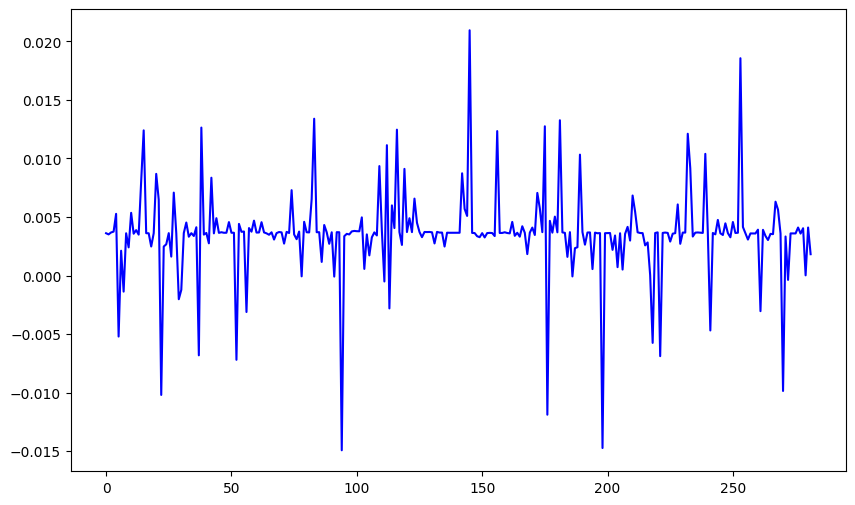

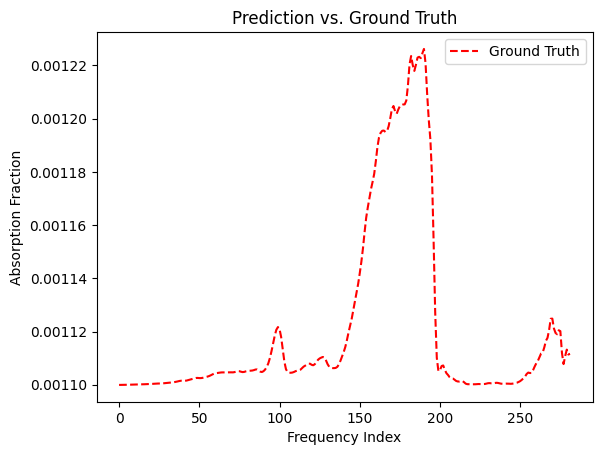

In [86]:
# Create a sample input as NumPy arrays (replace with your actual sample data)
example_clean = torch.from_numpy(demeaned_lc[100:101]).float()
example_raw = torch.from_numpy(demeaned_airs[100:101]).float()
example_psd = torch.from_numpy(normalized_psd_lc[100:101]).float()
ground_truth = torch.from_numpy(gt_df[100:101, :-2]).float()

# Run a sample prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    prediction = model(example_clean, example_raw, example_psd)

# Convert the prediction and ground truth to NumPy arrays for plotting
prediction_np = prediction.numpy().flatten()
ground_truth_np = ground_truth.numpy().flatten()

# Plot the prediction vs. ground truth
plt.figure(figsize=(10, 6))
plt.plot(prediction_np, label="Prediction", color="blue")
plt.show()
plt.plot(ground_truth_np, label="Ground Truth", color="red", linestyle="dashed")
plt.xlabel("Frequency Index")
plt.ylabel("Absorption Fraction")
plt.title("Prediction vs. Ground Truth")
plt.legend()
plt.show()

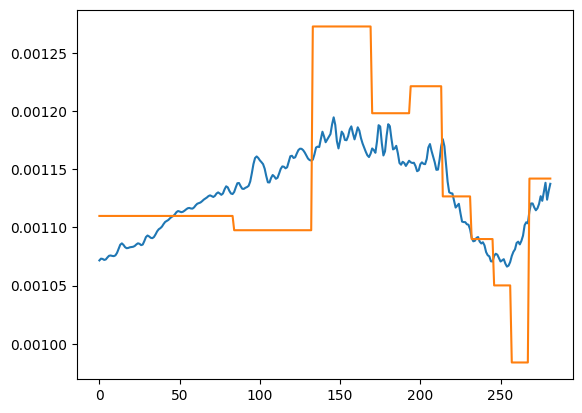

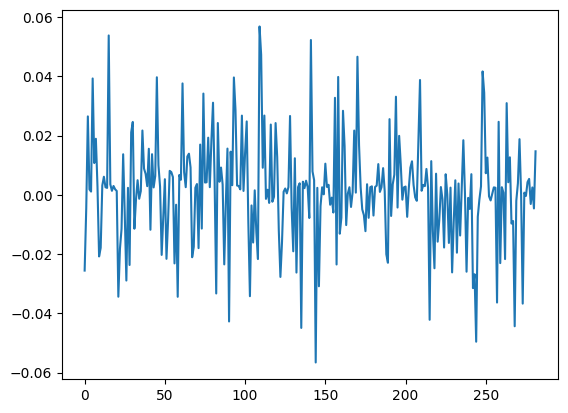

In [79]:
plt.plot(gt_df[0:1, :-2][0])
plt.plot(basic_fit_ratio[0])
plt.show()
plt.plot(prediction_np)

Data Input Visualizations ---------->

In [81]:
sigmas = np.load("../outputs/results/basic_fit/sigmas_single.npy")
wc_phases = np.load("../outputs/results/basic_fit/wc_phases.npy")

In [82]:
# we will use the below very promising features
# the demmeaned_wc and demeaned_lc, and the psd_lc

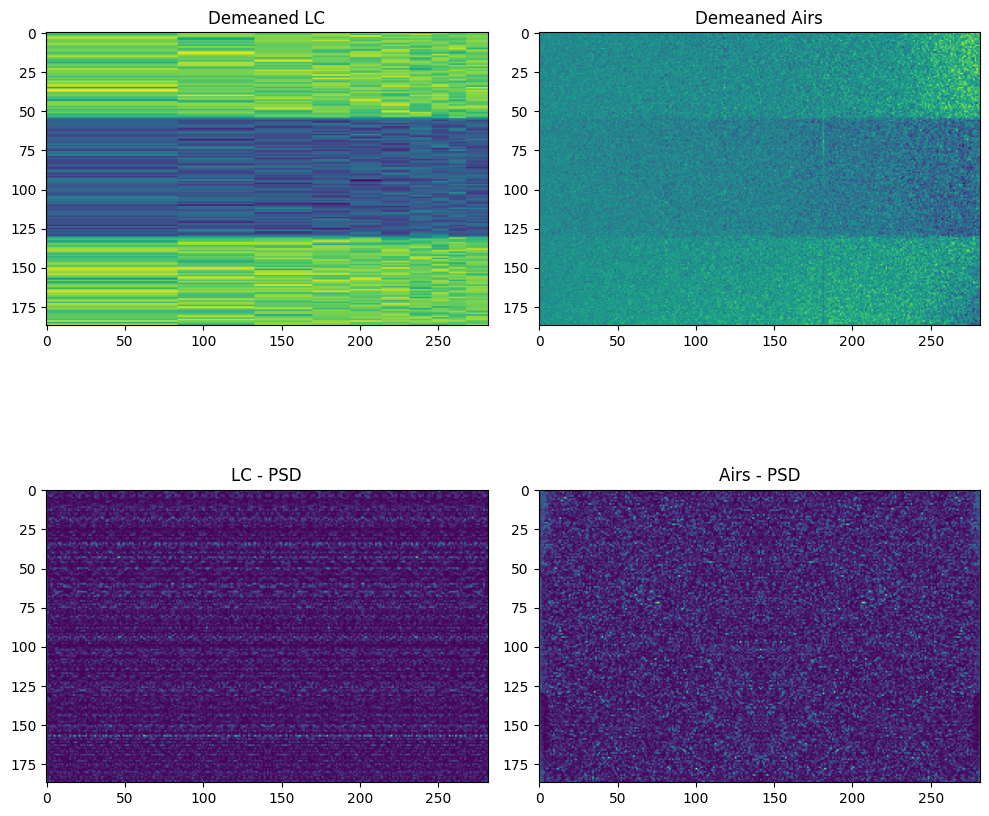

In [83]:
# Input data
observation_index = 100

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the first image
axs[0, 0].imshow(demeaned_lc[observation_index])
axs[0, 0].set_title("Demeaned LC")

# Plot the second image
axs[0, 1].imshow(demeaned_airs[observation_index])
axs[0, 1].set_title("Demeaned Airs")

# Plot the third image
axs[1, 0].imshow(normalized_psd_lc[observation_index])
axs[1, 0].set_title("LC - PSD")

# Plot the fourth image
axs[1, 1].imshow(normalized_psd_airs[observation_index])
axs[1, 1].set_title("Airs - PSD")

plt.tight_layout()
plt.show()

NameError: name 'freq_selected' is not defined

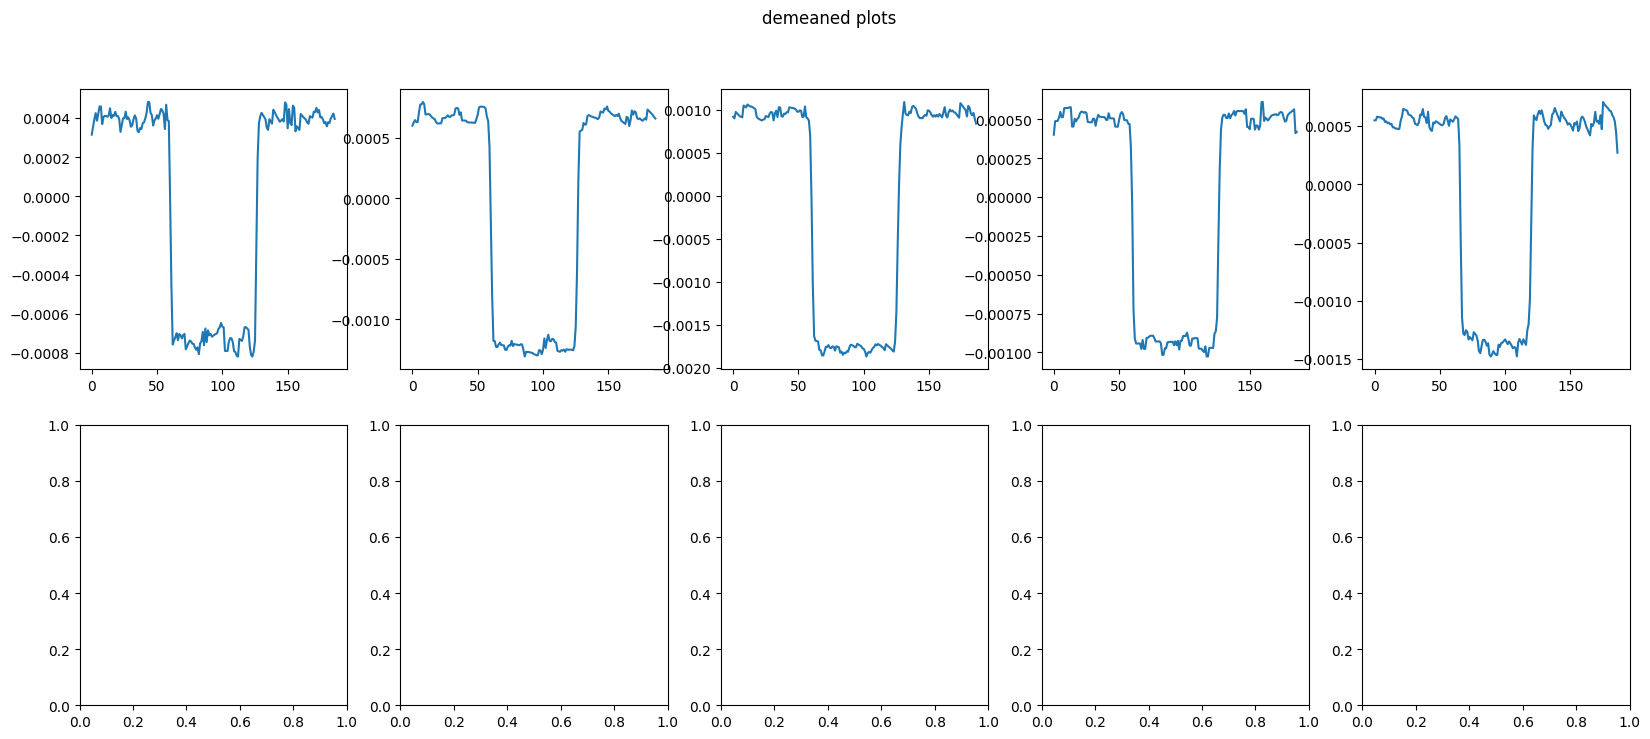

In [84]:
# Given that the demenaed wc has very boring PSD, we should ignore it for fear of overfitting noise
psd_wc = compute_spectral_density(demeaned_wc)  # we shall skip this

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("demeaned plots")
for i in range(5):
    axs[0, i].plot(demeaned_wc[i])

for i in range(5):
    axs[1, i].plot(demeaned_lc[i][:, freq_selected])
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

fig.suptitle("psd plots")
freq_selected = 50
for i in range(5):
    axs[0, i].plot(psd_wc[i])

for i in range(5):
    axs[1, i].plot(psd_lc[i][:, freq_selected])

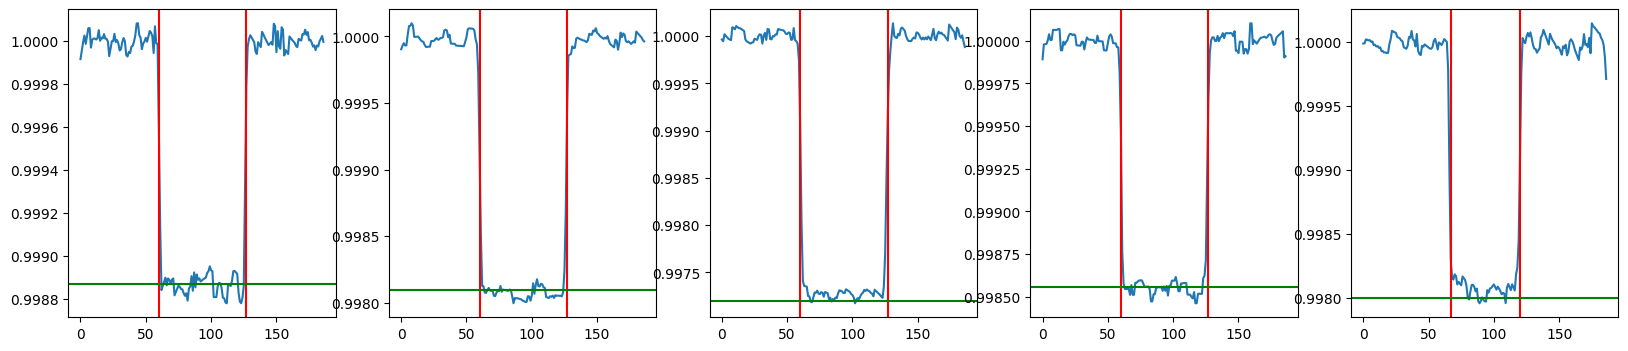

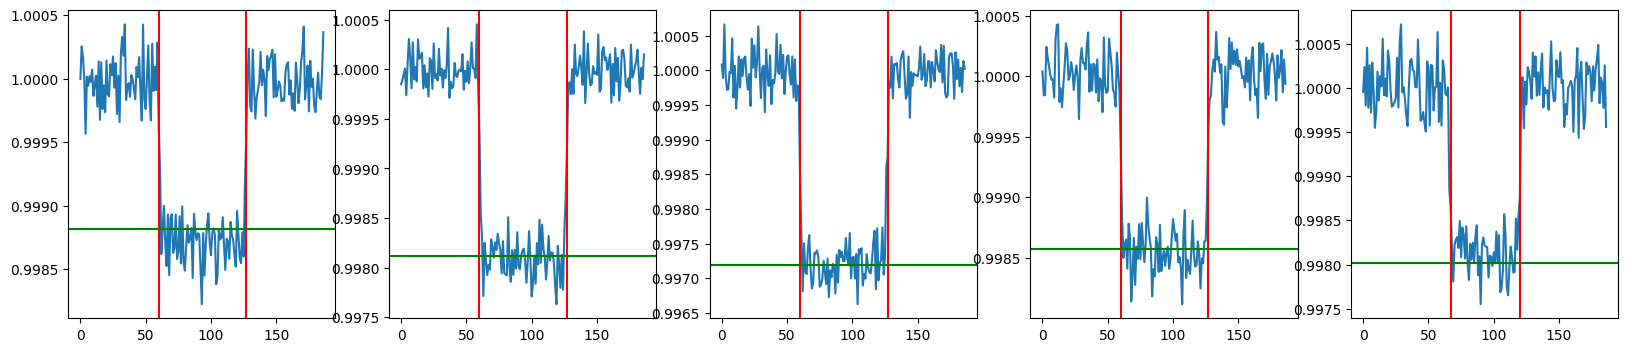

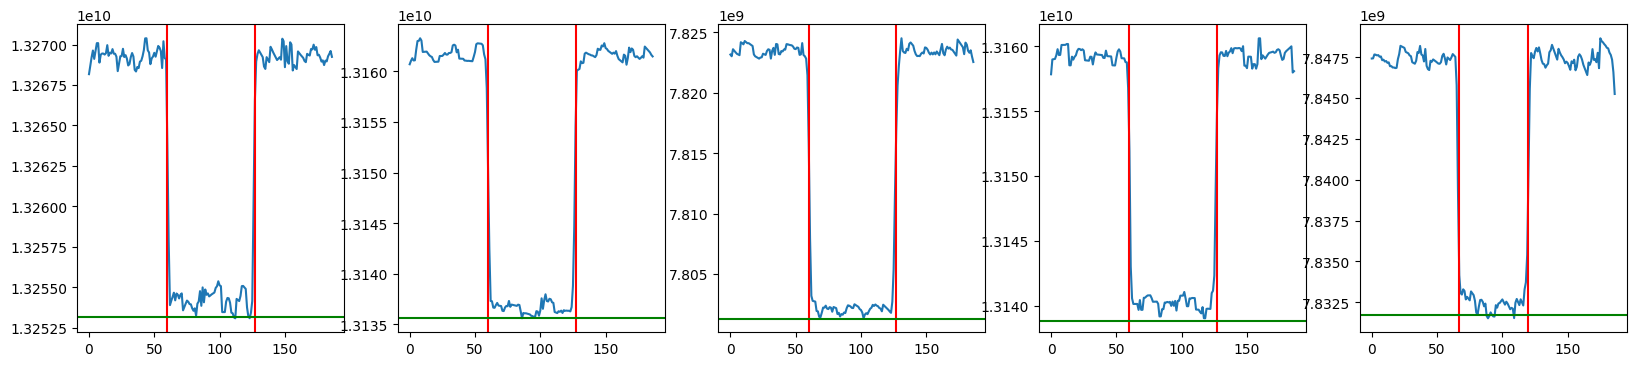

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    axs[i].plot(normalized_wc[i])
    axs[i].axvline(wc_phases[i][0], color="r")
    axs[i].axvline(wc_phases[i][1], color="r")
    axs[i].axhline((1 - gt_df.iloc[i, :-2].mean()), color="g")
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

freq_selected = 150
for i in range(5):
    axs[i].plot(normalized_lc[i][:, freq_selected])
    axs[i].axvline(wc_phases[i][0], color="r")
    axs[i].axvline(wc_phases[i][1], color="r")
    axs[i].axhline((1 - gt_df.iloc[i, freq_selected + 1].mean()), color="g")
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    axs[i].plot(fitted_wc[i])
    axs[i].axvline(wc_phases[i][0], color="r")
    axs[i].axvline(wc_phases[i][1], color="r")
    axs[i].axhline((1 - gt_df.iloc[i, :-2].mean()) * fitted_wc[i][0], color="g")
plt.show()